In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qmcpy import Halton

# Smooth approximation of max
def softmax(a, b, tau=1e-4):
    return 0.5 * (a + b + np.sqrt((a - b)**2 + tau))

#Code for the L_2 star
def L2(L):
    n=len(L)
    a=0
    for i in range(n):
        a+=(1-L[i][0]**2)*(1-L[i][1]**2)
    a=a/(2*n)
    
    b=0
    for i in range(n):
        for j in range(n):
            b+=(1-max(L[i][0],L[j][0]))*(1-max(L[i][1],L[j][1]))
    b=b/(n**2)
    
    return(1/9-a+b)

def edge_penalty(P, epsilon=1e-9):
    """
    Penalize points near the boundary (x=0 or 1).
    P: array of shape (n, d)
    epsilon: small constant to avoid division by zero
    """
    return np.sum(1.0 / ((P + epsilon) * (1.0 - P + epsilon)))

def repulsion_penalty(P, epsilon=1e-9):
    n = len(P)
    total = 0.0
    for i in range(n):
        for j in range(i+1, n):
            dist_squared = np.sum((P[i] - P[j])**2)
            total += 1.0 / (dist_squared + epsilon)
    return total

# Smoothed L2 star discrepancy objective
def L2_smoothed(P, tau=1e-4):
    n = len(P)
    a=0
    for i in range(n):
        a+=(1-P[i][0]**2)*(1-P[i][1]**2)
    a=a/(2*n)

    b = 0
    for i in range(n):
        for j in range(n):
            smax0 = softmax(P[i, 0], P[j, 0], tau)
            smax1 = softmax(P[i, 1], P[j, 1], tau)
            b += (1 - smax0) * (1 - smax1)
    b = b / (n**2)

    return 1/9 - a + b

# Smoothed L2 star discrepancy objective
def L2_updated(P, tau=1e-4):
    n = len(P)
    a=0
    for i in range(n):
        a+=(1-P[i][0]**2)*(1-P[i][1]**2)
    a=a/(2*n)

    b = 0
    for i in range(n):
        for j in range(n):
            smax0 = softmax(P[i, 0], P[j, 0], tau)
            smax1 = softmax(P[i, 1], P[j, 1], tau)
            b += (1 - smax0) * (1 - smax1)
    b = b / (n**2)

    return 1/9 - a + b + 1e-7 * edge_penalty(P) + 1e-8 * repulsion_penalty(P)

# Project points to [0,1)
def project_to_unit_cube(P):
    return np.clip(P, 0, 1 - 1e-8)

def locdisc(x, y, P):
    no = 0
    nc = 0
    n = len(P)
    for i in range(n):
        if P[i][0] < x and P[i][1] < y:
            no += 1
        if P[i][0] <= x and P[i][1] <= y:
            nc += 1
    return max(x*y - no/n, nc/n - x*y)

def heatmap_from_array(P):  # P should be a NumPy array of shape (n, 2)
    n = len(P)
    PX = P[:, 0]
    PY = P[:, 1]
    
    X = [0.001 * i for i in range(1001)]
    Y = [0.001 * i for i in range(1001)]
    Z = [[0 for _ in range(1001)] for _ in range(1001)]
    
    maxi = 0
    mxii = 0
    mxjj = 0
    for i in range(1001):
        for j in range(1001):
            Z[j][i] = locdisc(X[i], Y[j], P)
            if Z[j][i] > maxi:
                maxi = Z[j][i]
                mxii = i
                mxjj = j

    plt.figure(figsize=(7,6))
    cs = plt.contourf(X, Y, Z, levels=40, cmap="viridis")
    plt.colorbar(cs)
    plt.scatter(PX, PY, c='r', s=50, linewidth=1, alpha=0.7)
    plt.scatter(mxii/1000, mxjj/1000, c='black')
    plt.title("Local Discrepancy Heatmap")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.show()

In [2]:
def PGD_L2(start_points, max_iters=100, alpha=0.1, beta=0.5, tau=1e-4, tol=1e-6):
    n = len(start_points)
    P = start_points.copy()
    obj_values = []

    for it in range(max_iters):
        grad = np.zeros_like(P)
        eps = 1e-6
        f_val = L2_smoothed(P, tau)

        # Finite difference gradient
        for i in range(n):
            for j in range(2):
                P_perturbed = P.copy()
                P_perturbed[i, j] += eps
                f_perturbed = L2_smoothed(P_perturbed, tau)
                grad[i, j] = (f_perturbed - f_val) / eps

        # Backtracking line search
        t = 1.0
        while True:
            new_P = project_to_unit_cube(P - t * grad)
            if L2_smoothed(new_P, tau) <= f_val - alpha * t * np.sum(grad**2):
                break
            t *= beta
            if t < 1e-8:
                break

        P_new = new_P
        obj_new = L2(P_new)
        obj_values.append(obj_new)

        if np.linalg.norm(P_new - P) < tol:
            break
        P = P_new

    return P, obj_values

In [3]:
def PGD_L2_updated(start_points, max_iters=100, alpha=0.1, beta=0.5, tau=1e-4, tol=1e-6):
    n = len(start_points)
    P = start_points.copy()
    obj_values = []

    for it in range(max_iters):
        grad = np.zeros_like(P)
        eps = 1e-6
        f_val = L2_updated(P, tau)

        # Finite difference gradient
        for i in range(n):
            for j in range(2):
                P_perturbed = P.copy()
                P_perturbed[i, j] += eps
                f_perturbed = L2_updated(P_perturbed, tau)
                grad[i, j] = (f_perturbed - f_val) / eps

        # Backtracking line search
        t = 1.0
        while True:
            new_P = project_to_unit_cube(P - t * grad)
            if L2_updated(new_P, tau) <= f_val - alpha * t * np.sum(grad**2):
                break
            t *= beta
            if t < 1e-8:
                break

        P_new = new_P
        obj_new = L2(P_new)
        obj_values.append(obj_new)

        if np.linalg.norm(P_new - P) < tol:
            break
        P = P_new

    return P, obj_values

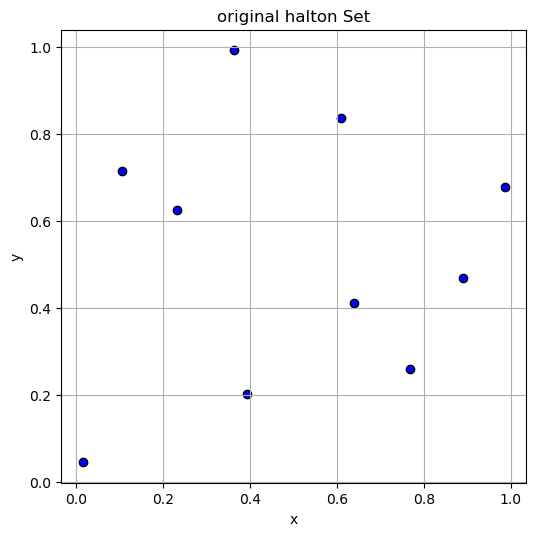

Points: [[0.98715846 0.67772039]
 [0.01551164 0.04478333]
 [0.63910487 0.41123494]
 [0.36258846 0.99152052]
 [0.76866525 0.25800598]
 [0.23257102 0.62491462]
 [0.6090882  0.83487439]
 [0.39312437 0.20148029]
 [0.89069538 0.46781144]
 [0.10660389 0.71367715]]


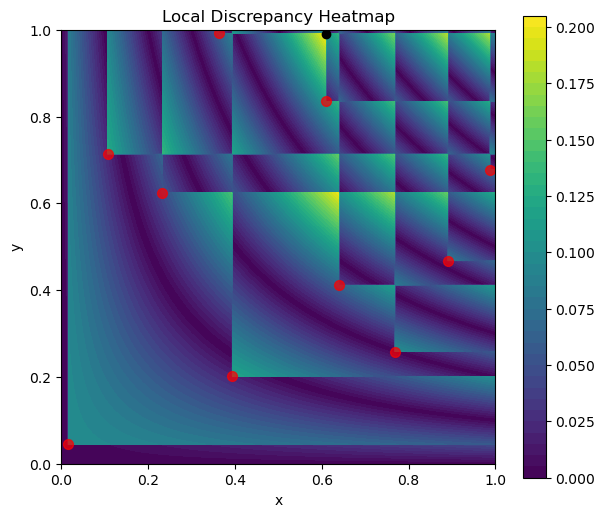

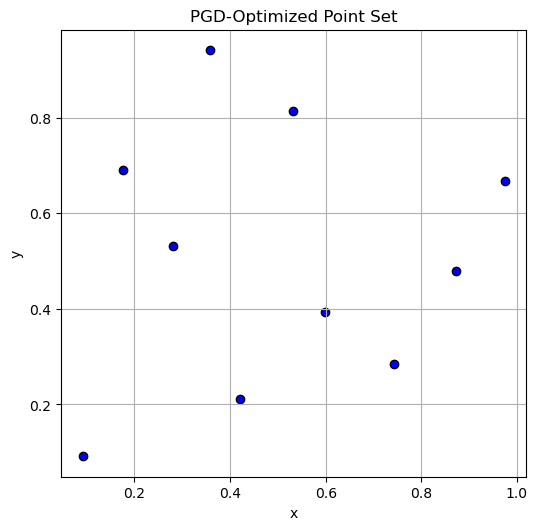

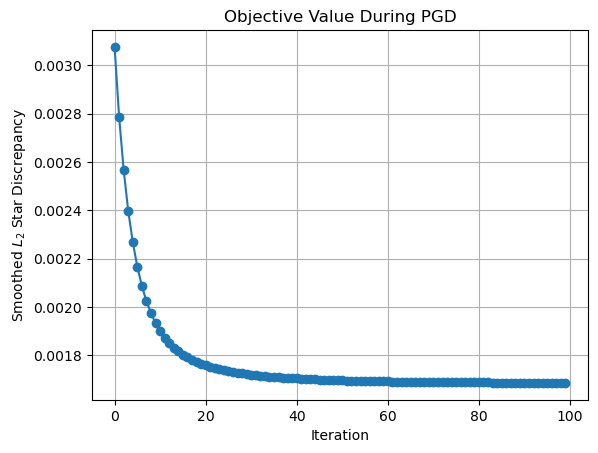

initial set L2 star discrepancy: 0.003460409642369683
Final discrepancy value: 0.0016861085039607954
Points: [[0.97547846 0.666568  ]
 [0.09147504 0.09141868]
 [0.59883511 0.39287452]
 [0.35800736 0.94157204]
 [0.74205972 0.285674  ]
 [0.28085866 0.53073317]
 [0.53135145 0.81433816]
 [0.4217322  0.21068612]
 [0.87164995 0.47873431]
 [0.17578676 0.69069483]]


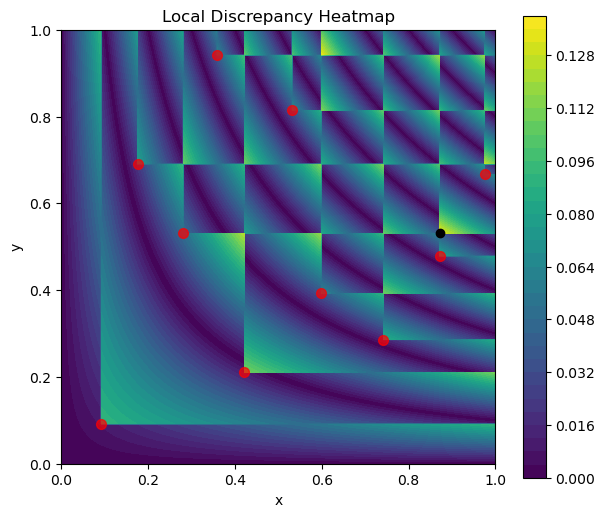

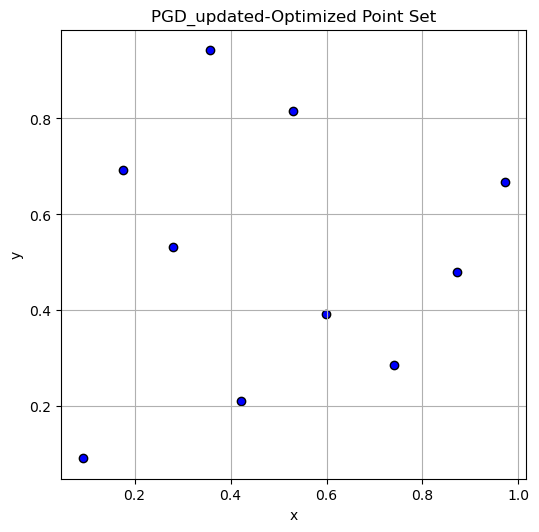

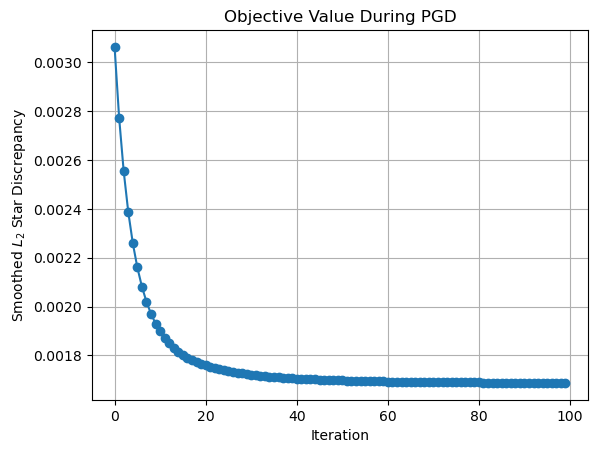

initial set L2 star discrepancy: 0.003460409642369683
Final discrepancy value: 0.001687269804975397
Points: [[0.97251779 0.66664857]
 [0.09157837 0.09152396]
 [0.59814586 0.39308004]
 [0.35794324 0.94234256]
 [0.74143052 0.28568282]
 [0.2806408  0.53114632]
 [0.53115144 0.81548937]
 [0.42134019 0.21073716]
 [0.87089382 0.47882504]
 [0.17570874 0.69172241]]


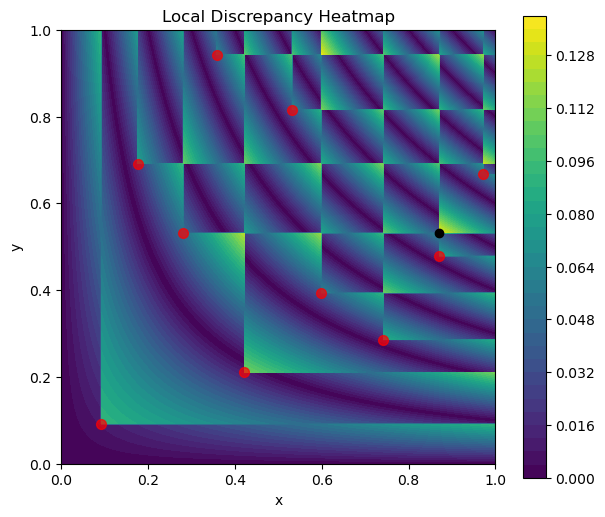

In [4]:
n = 10
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)

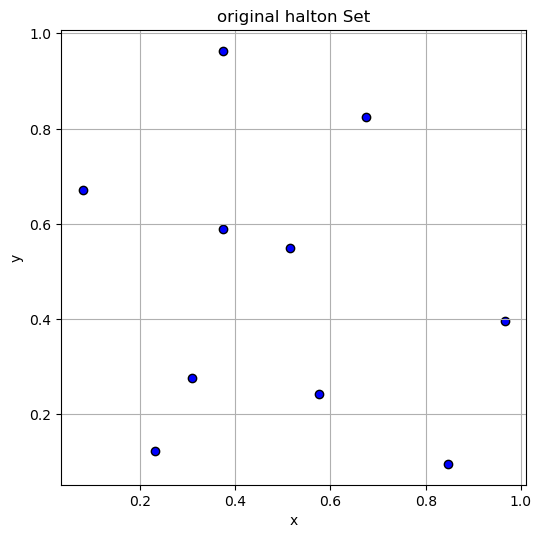

Points: [[0.30867174 0.27645555]
 [0.51496964 0.54856126]
 [0.07944306 0.67086983]
 [0.84580146 0.09578819]
 [0.37521093 0.58889106]
 [0.67525878 0.82355329]
 [0.23191356 0.12364291]
 [0.96702191 0.39587781]
 [0.37361348 0.96402005]
 [0.57600704 0.2426243 ]]


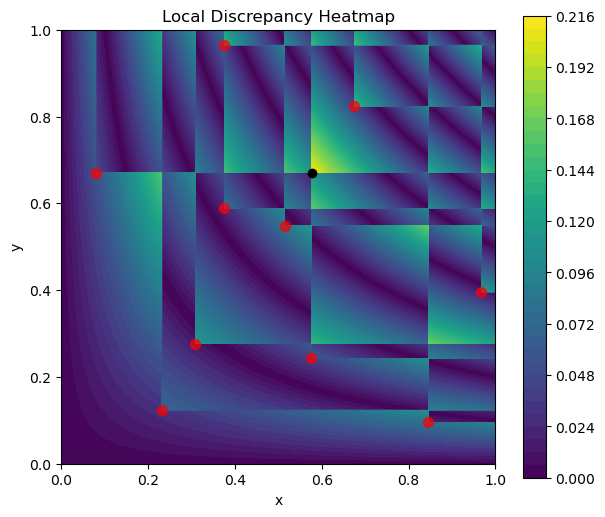

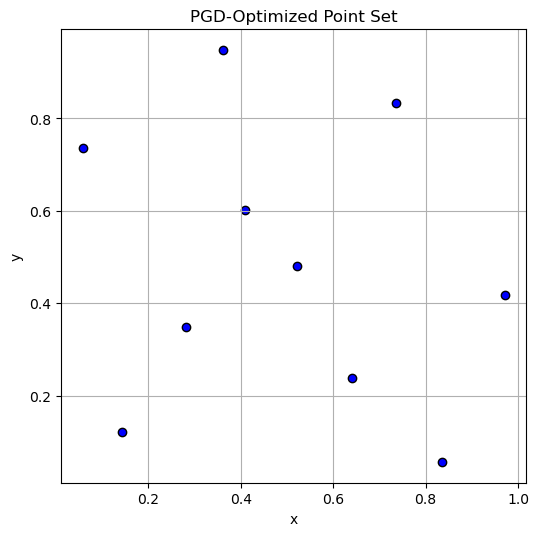

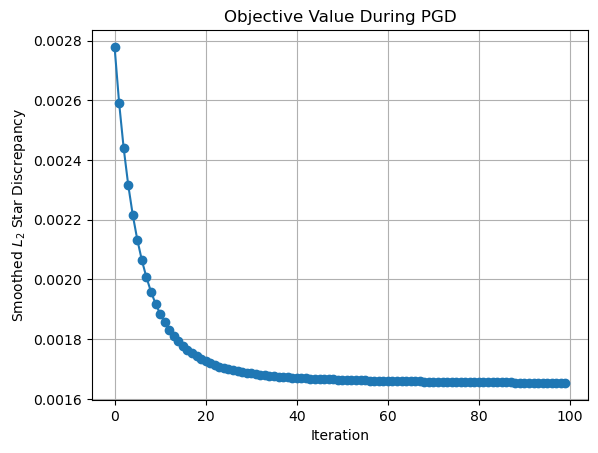

initial set L2 star discrepancy: 0.0030131644055825108
Final discrepancy value: 0.0016531777973035205
Points: [[0.28214606 0.34757706]
 [0.52219243 0.48001439]
 [0.05723323 0.73558662]
 [0.83447254 0.05579031]
 [0.40972209 0.6019151 ]
 [0.73516574 0.83327634]
 [0.1423632  0.12098195]
 [0.97240892 0.41845804]
 [0.36238428 0.94779832]
 [0.64115226 0.23846467]]


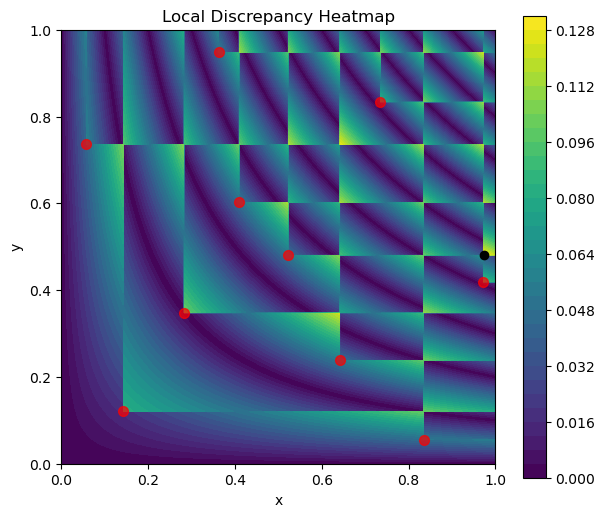

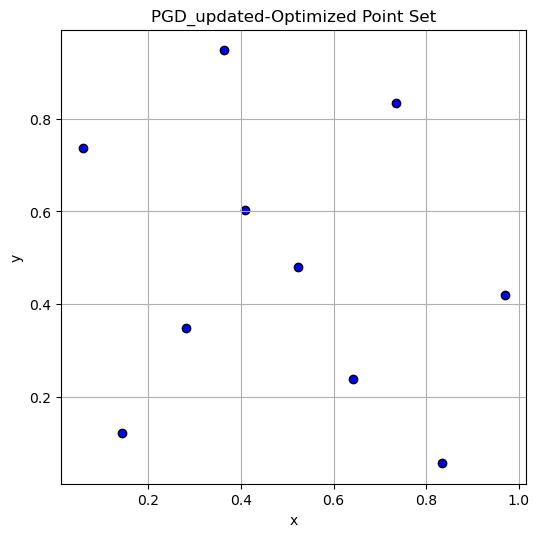

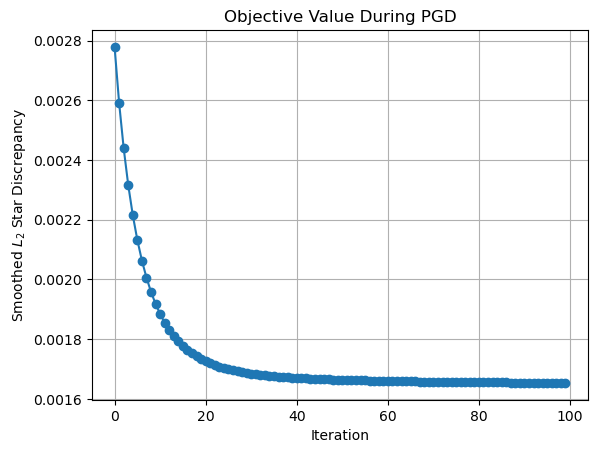

initial set L2 star discrepancy: 0.0030131644055825108
Final discrepancy value: 0.0016535120166134426
Points: [[0.28201902 0.34775605]
 [0.52195583 0.48067487]
 [0.05783193 0.73618198]
 [0.83387988 0.0566226 ]
 [0.40953778 0.60260685]
 [0.73511814 0.83408714]
 [0.14229076 0.1211329 ]
 [0.97040533 0.41953258]
 [0.36239298 0.94800946]
 [0.64075448 0.23861348]]


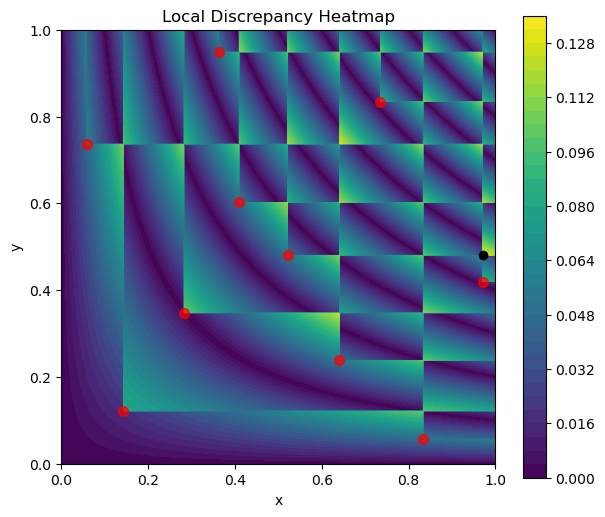

In [9]:
n = 10
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)

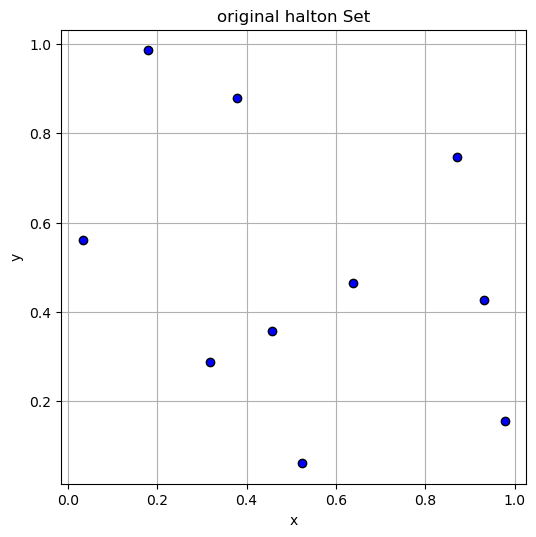

Points: [[0.45665549 0.35809249]
 [0.9793058  0.15624729]
 [0.17950486 0.98564147]
 [0.63916879 0.46535851]
 [0.31745749 0.28789336]
 [0.8713448  0.74676497]
 [0.03258878 0.55995092]
 [0.5234859  0.06134632]
 [0.37856355 0.87870467]
 [0.93257316 0.42636962]]


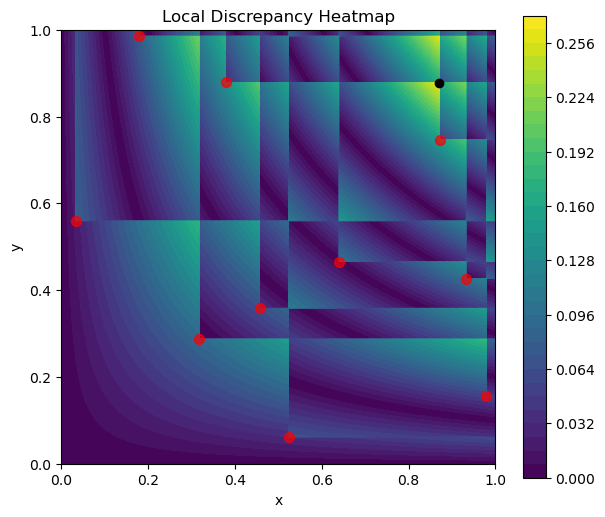

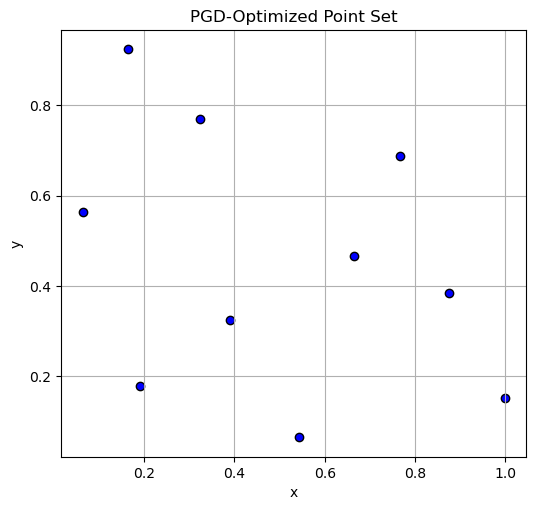

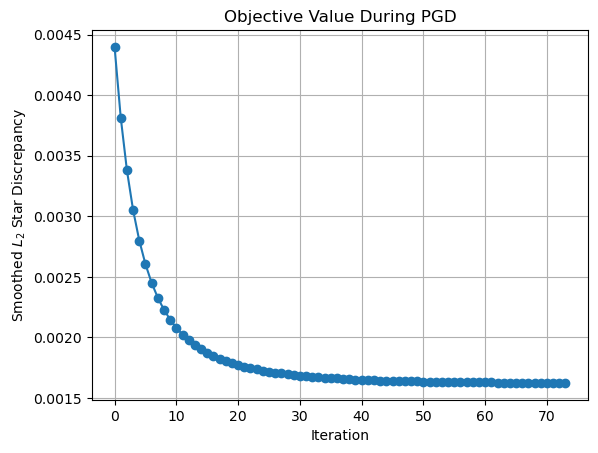

initial set L2 star discrepancy: 0.005194804213854279
Final discrepancy value: 0.0016237252682731323
Points: [[0.39103117 0.32390762]
 [0.99999999 0.15212025]
 [0.16419162 0.92402625]
 [0.66529193 0.46563089]
 [0.18956215 0.17901553]
 [0.76703835 0.68748048]
 [0.06333433 0.56341188]
 [0.54216511 0.0645652 ]
 [0.3227867  0.77071045]
 [0.8755888  0.38517902]]


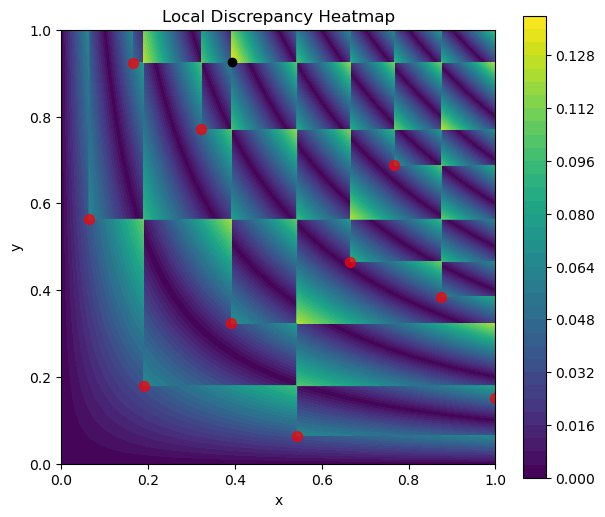

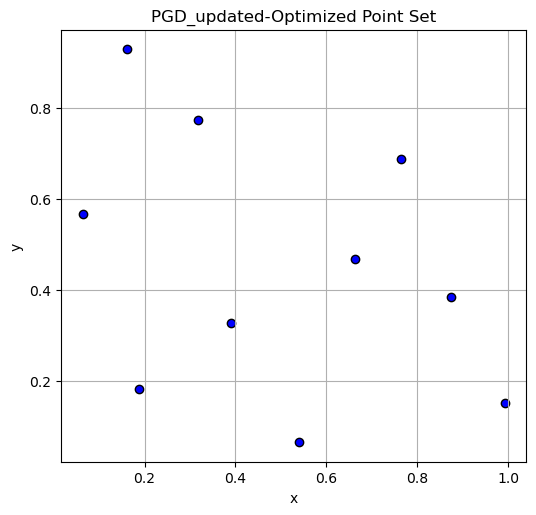

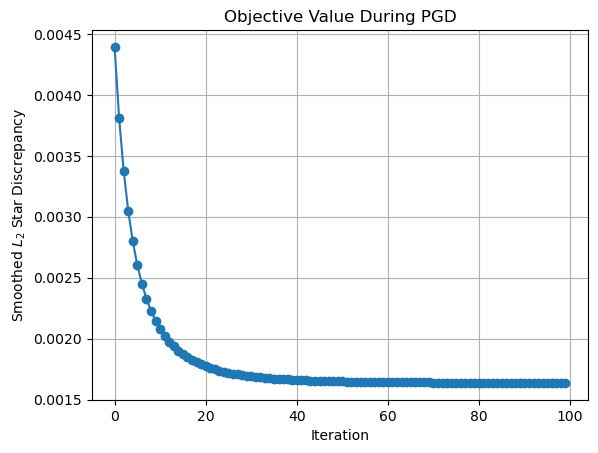

initial set L2 star discrepancy: 0.005194804213854279
Final discrepancy value: 0.0016370869750955974
Points: [[0.38922672 0.32561268]
 [0.99299694 0.15104151]
 [0.16156024 0.92838316]
 [0.66331375 0.46790682]
 [0.18831393 0.18050528]
 [0.76368037 0.68806077]
 [0.06377951 0.56583555]
 [0.5402926  0.06489243]
 [0.3184553  0.7738399 ]
 [0.87396314 0.38349822]]


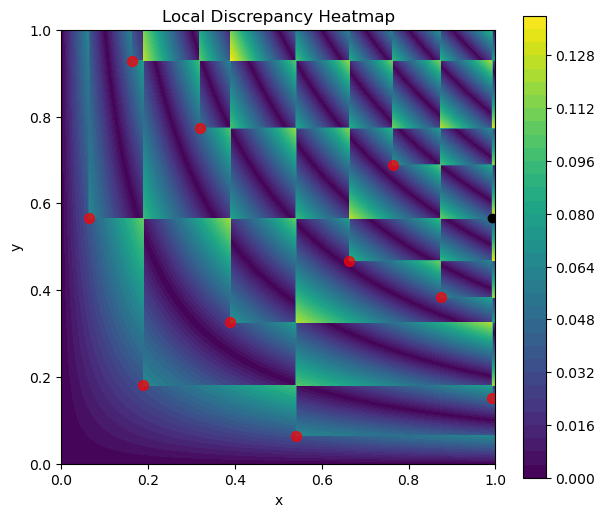

In [11]:
n = 10
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)

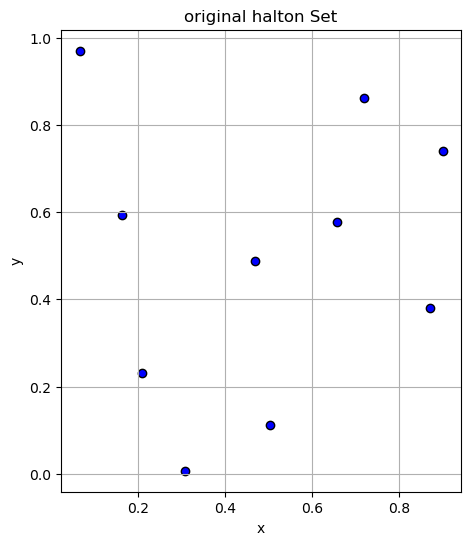

Points: [[0.16319944 0.59298255]
 [0.71971282 0.86167105]
 [0.30874486 0.00693635]
 [0.87087334 0.380427  ]
 [0.06667882 0.97008601]
 [0.50356613 0.11123065]
 [0.46825096 0.48868973]
 [0.89903467 0.74089454]
 [0.21102689 0.23185579]
 [0.65621489 0.5779547 ]]


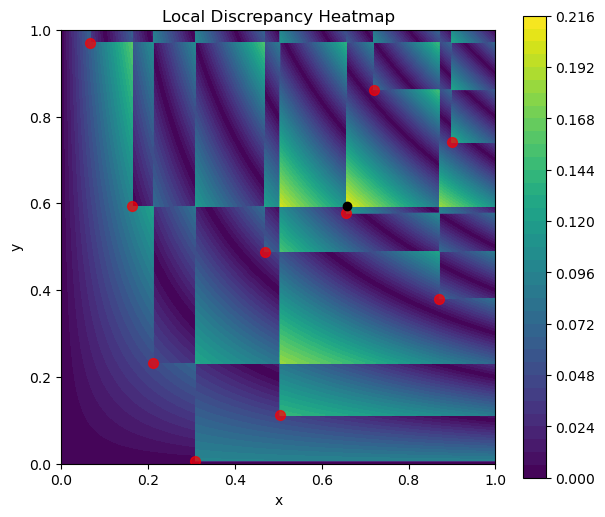

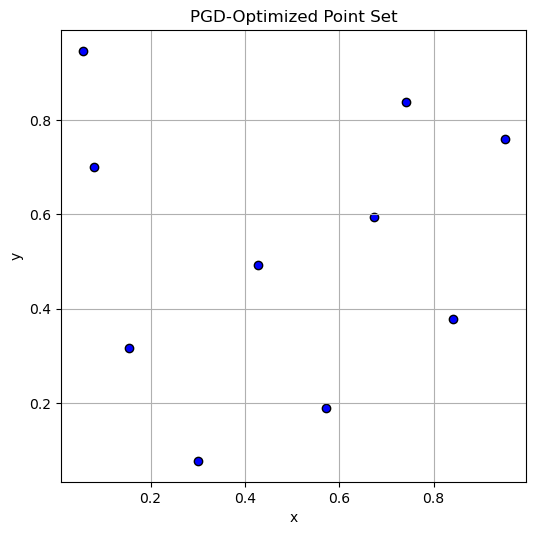

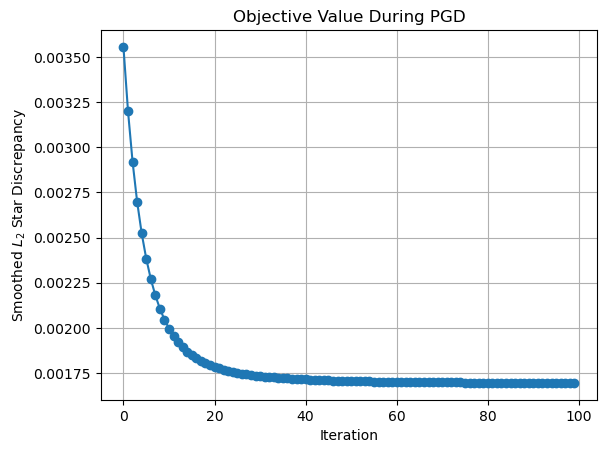

initial set L2 star discrepancy: 0.004006134497948552
Final discrepancy value: 0.0016951331715951007
Points: [[0.07965755 0.70049632]
 [0.74052229 0.83750663]
 [0.3013919  0.0765436 ]
 [0.84132441 0.37738802]
 [0.05578608 0.94662063]
 [0.57258428 0.1898242 ]
 [0.42829857 0.49236617]
 [0.95183271 0.75940098]
 [0.15428366 0.31663822]
 [0.67403066 0.59363905]]


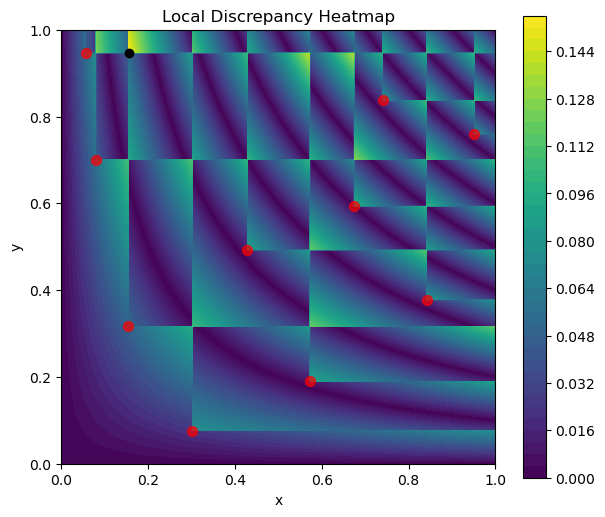

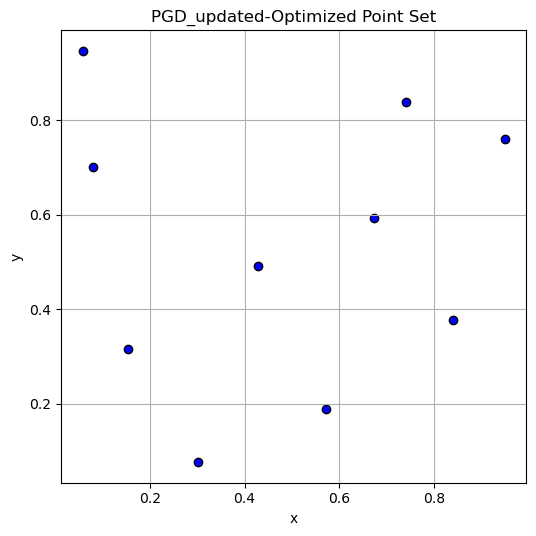

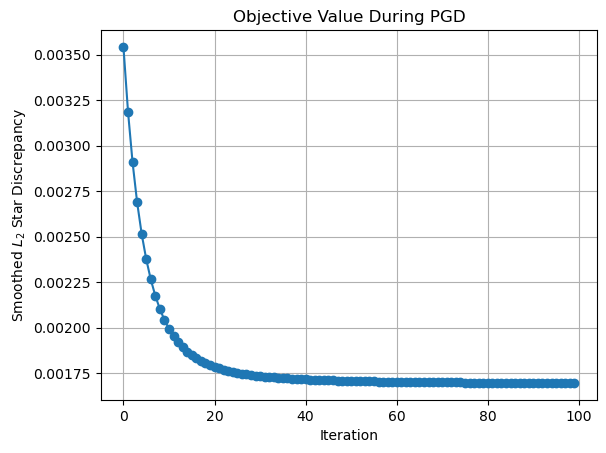

initial set L2 star discrepancy: 0.004006134497948552
Final discrepancy value: 0.0016954522944100658
Points: [[0.08003007 0.70030094]
 [0.74071298 0.83763584]
 [0.30152674 0.07670632]
 [0.84146177 0.37734671]
 [0.05758029 0.94613538]
 [0.5727469  0.18982965]
 [0.42846694 0.49228624]
 [0.95116227 0.75945752]
 [0.15445446 0.31658873]
 [0.67422285 0.59355841]]


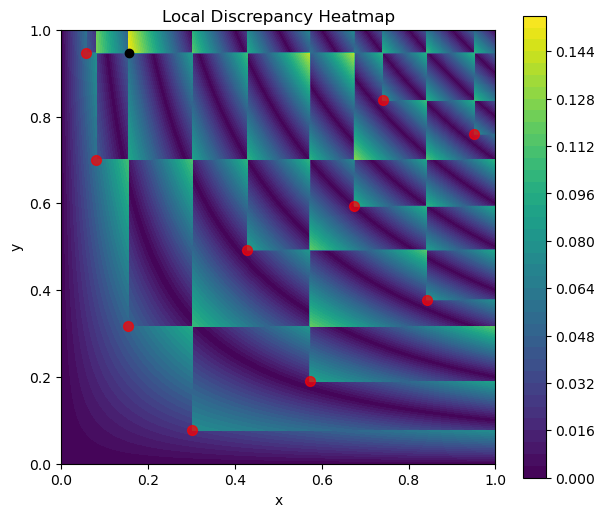

In [13]:
n = 10
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)

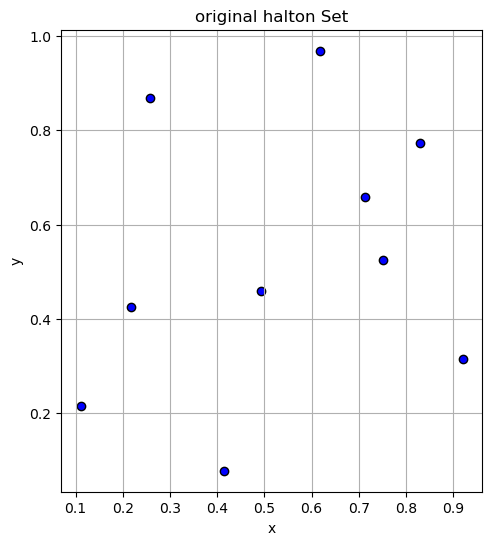

Points: [[0.75187728 0.52563068]
 [0.41433008 0.07846922]
 [0.61686609 0.96860368]
 [0.21680271 0.42568299]
 [0.92091542 0.31583441]
 [0.25652425 0.86867858]
 [0.71217275 0.65847592]
 [0.1102673  0.21543513]
 [0.82974776 0.7724056 ]
 [0.49220032 0.45944934]]


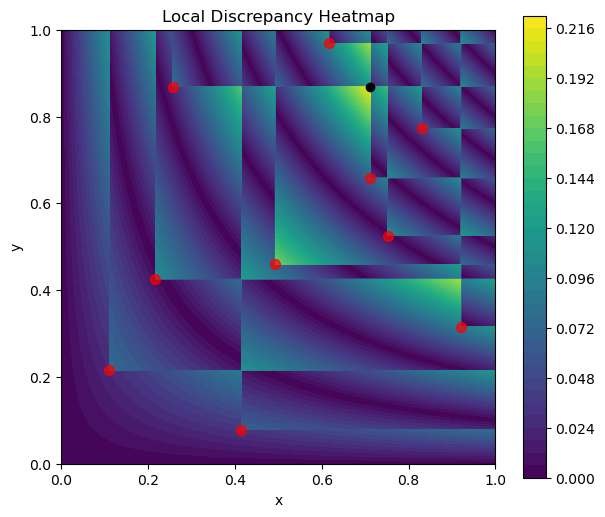

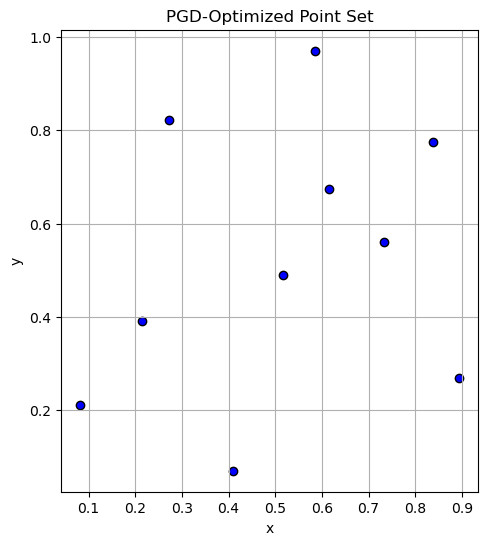

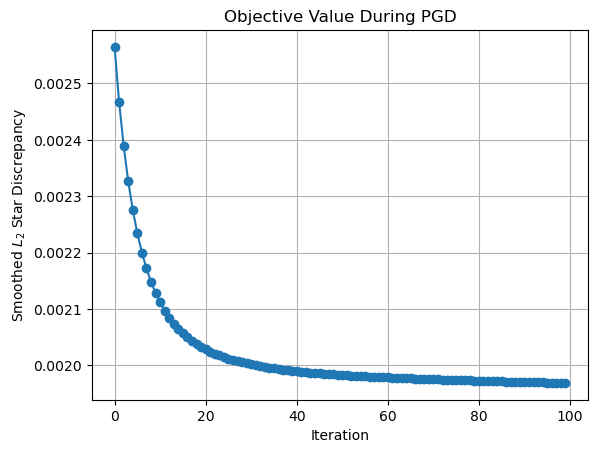

initial set L2 star discrepancy: 0.0026885960072830506
Final discrepancy value: 0.0019687581323908493
Points: [[0.73283661 0.56157213]
 [0.40999356 0.07057786]
 [0.5847372  0.97054653]
 [0.21521924 0.39213359]
 [0.89353585 0.26875772]
 [0.27190086 0.82146136]
 [0.61439077 0.67474115]
 [0.08234837 0.21080755]
 [0.83762474 0.77425743]
 [0.51673453 0.48915824]]


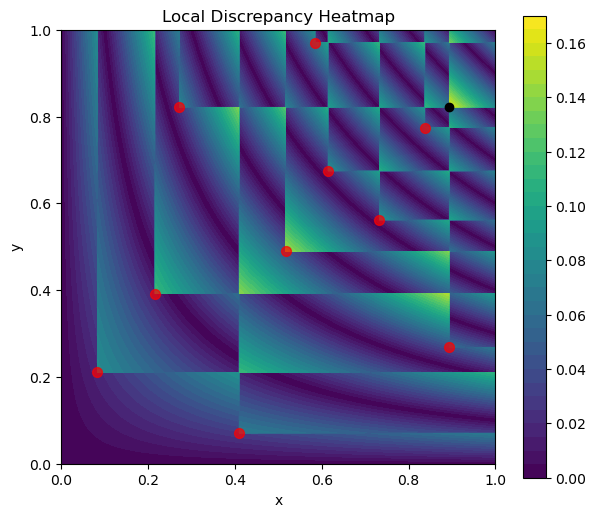

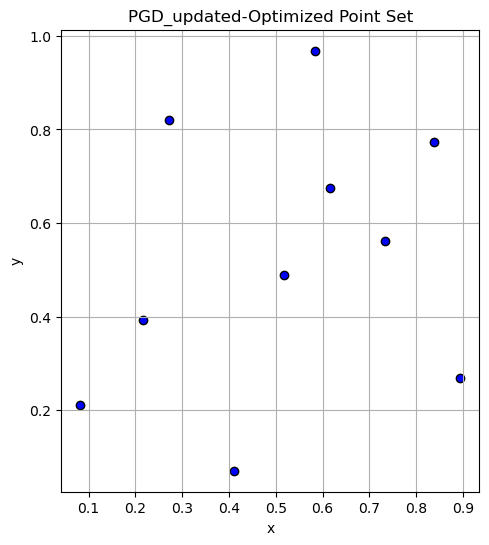

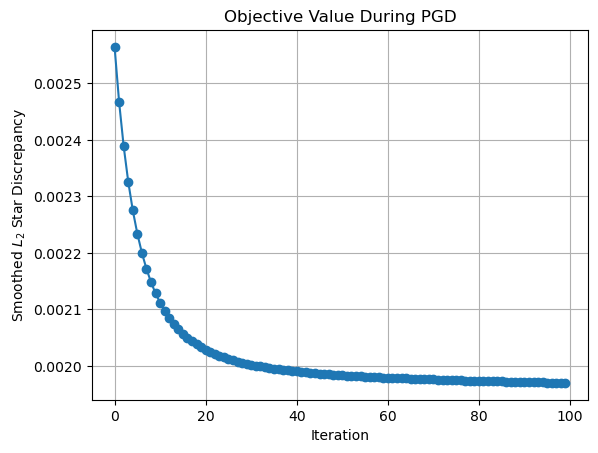

initial set L2 star discrepancy: 0.0026885960072830506
Final discrepancy value: 0.00196974376833306
Points: [[0.73371931 0.56116976]
 [0.4101388  0.0707986 ]
 [0.58426561 0.9683491 ]
 [0.21525711 0.39199797]
 [0.89424202 0.26874771]
 [0.27197533 0.82074137]
 [0.61522368 0.67432362]
 [0.08248452 0.21077942]
 [0.83868083 0.77400513]
 [0.51690126 0.48894442]]


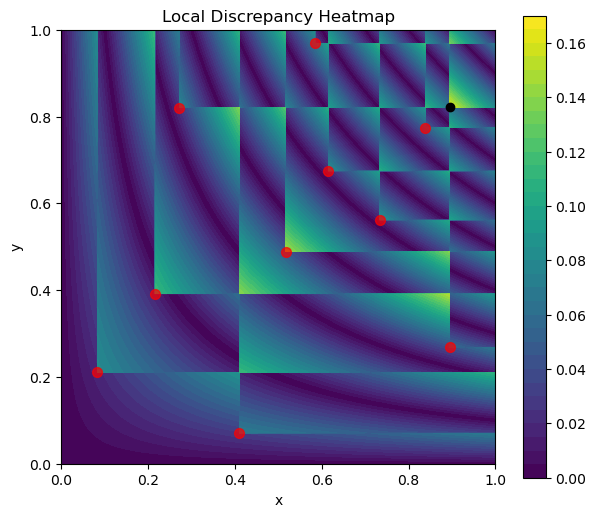

In [15]:
n = 10
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)

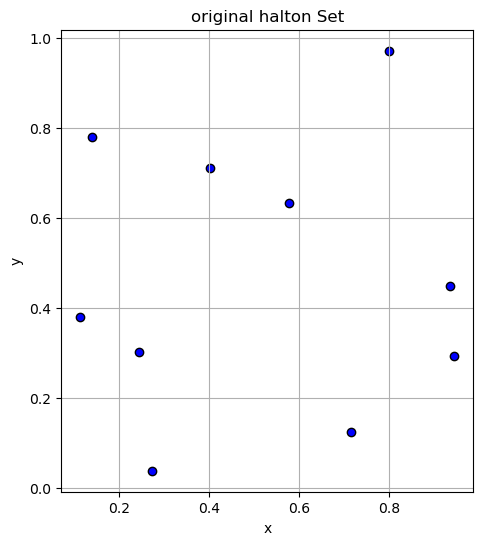

Points: [[0.2437756  0.30290332]
 [0.93641487 0.44945802]
 [0.40122621 0.71058471]
 [0.71640323 0.12344563]
 [0.11367564 0.38045703]
 [0.7999445  0.97140599]
 [0.27256832 0.03798389]
 [0.57849079 0.63304794]
 [0.14000222 0.77960242]
 [0.94543255 0.2921873 ]]


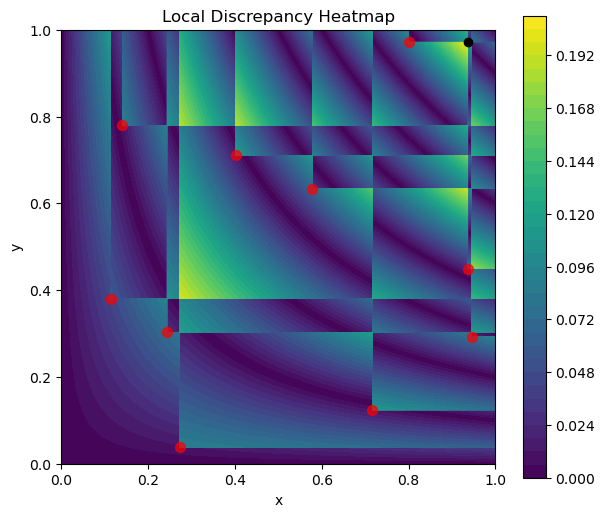

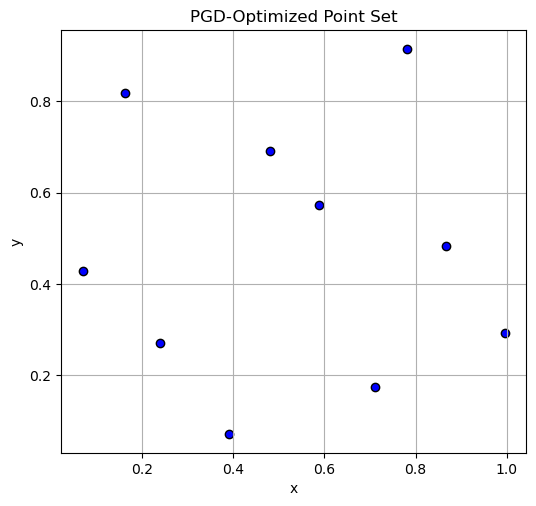

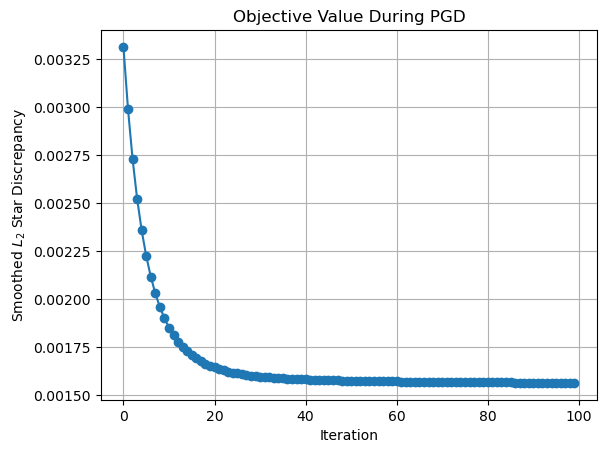

initial set L2 star discrepancy: 0.0037111475499800595
Final discrepancy value: 0.0015646585964223525
Points: [[0.24029122 0.27106289]
 [0.8658527  0.48353459]
 [0.48056889 0.69118372]
 [0.71158046 0.17425678]
 [0.06972227 0.4276444 ]
 [0.78201013 0.91411089]
 [0.39040048 0.07167711]
 [0.58880203 0.57182224]
 [0.16238482 0.81862583]
 [0.99660793 0.29265859]]


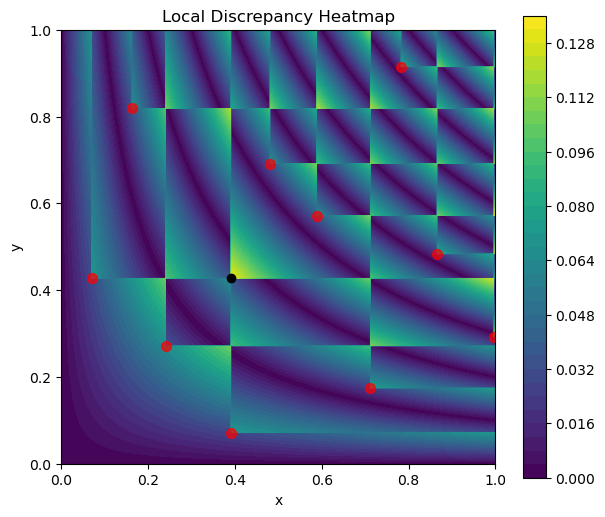

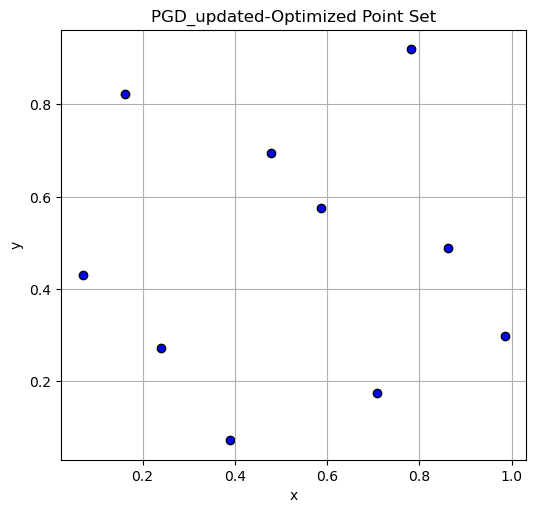

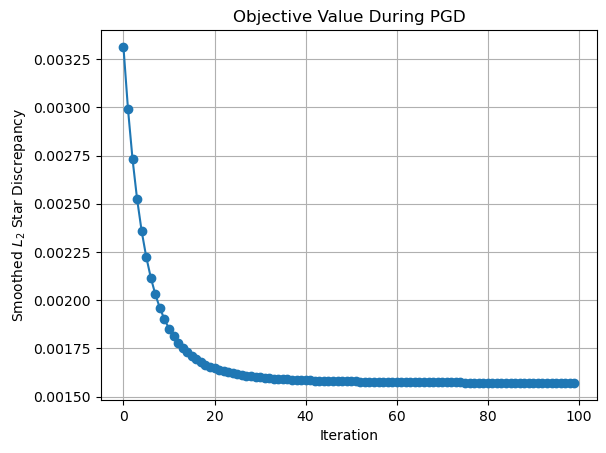

initial set L2 star discrepancy: 0.0037111475499800595
Final discrepancy value: 0.0015704943206783645
Points: [[0.23911259 0.27179534]
 [0.86189957 0.48920462]
 [0.47922358 0.69535243]
 [0.70882002 0.17450257]
 [0.06983782 0.43039072]
 [0.78130709 0.91896797]
 [0.38913031 0.07193833]
 [0.58684737 0.57602624]
 [0.16223044 0.82261214]
 [0.98606266 0.29756227]]


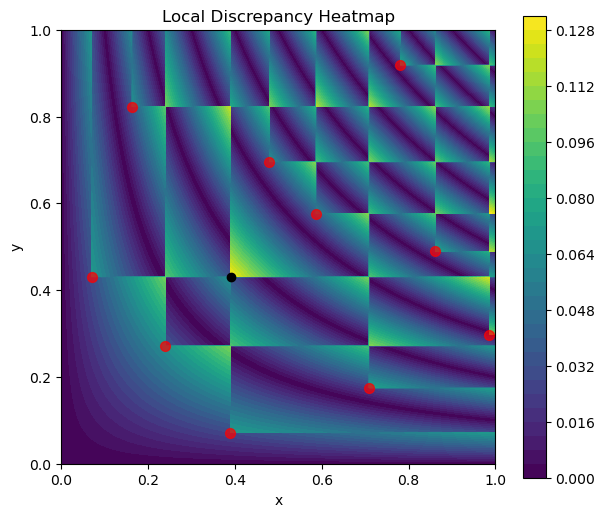

In [17]:
n = 10
d = 2
halton_net = Halton(dimension=d)
init_points = halton_net.gen_samples(n)

plt.figure(figsize=(6,6))
plt.scatter(init_points[:, 0], init_points[:, 1], c='blue', edgecolor='black')
plt.title("original halton Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

print("Points:", init_points)

heatmap_from_array(init_points)



initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)




initial_discrepancy_value = L2(init_points)

optimized_points, objective_history = PGD_L2_updated(init_points)

# === Plot final points ===
plt.figure(figsize=(6,6))
plt.scatter(optimized_points[:, 0], optimized_points[:, 1], c='blue', edgecolor='black')
plt.title("PGD_updated-Optimized Point Set")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

# === Plot objective value ===
plt.figure()
plt.plot(objective_history, marker='o')
plt.title("Objective Value During PGD")
plt.xlabel("Iteration")
plt.ylabel("Smoothed $L_2$ Star Discrepancy")
plt.grid(True)
plt.show()

# === Output a few results ===
print("initial set L2 star discrepancy:", initial_discrepancy_value)
print("Final discrepancy value:", objective_history[-1])
print("Points:", optimized_points)

heatmap_from_array(optimized_points)